In [2]:
import numpy as np
import matplotlib.pyplot as plt  
from scipy.integrate import odeint
from gekko import GEKKO
from scipy.integrate import simpson
from scipy.linalg import solve

# Contrôle optimal - T.P. no 3
## Contrôle optimal de l'équation de la chaleur

On considère une barre unidimensionnelle de longueur $ L > 0 $. La température de l'extrémité gauche de la barre (en $ x = 0 $) est maintenue à 0 K et on cherche à contrôler la température de la barre à l'extrémité droite (en $ x = L $) à l'aide d'un flux de chaleur $ t \rightarrow u(t) $. On appelle $ y_u(t, x) $ la température de cette barre au temps $ t \in [0, T] $ et en $ x \in [0, L] $.

On suppose donc que $ y_u $ résout l'équation de la chaleur
$$
\begin{cases}
\partial_t y_u(t, x) - \partial_{xx} y_u(t, x) = 0 & (t, x) \in ]0, T[ \times ]0, L[ \\
y_u(0, x) = 0 & x \in [0, L] \\
y_u(t, 0) = 0 & t \in [0, T] \quad \text{(condition de Dirichlet homogène)} \\
\partial_x y_u(t, L) = u(t) & t \in [0, T] \quad \text{(condition de Neumann non-homogène)}
\end{cases}
$$
et on s'intéresse au problème de contrôle optimal
$$
\inf_{u \in L^2(]0, T[)} J(u) \quad \text{où} \quad J(u) = \frac{1}{2} \int_0^T (y_u(t, L) - z_d(t))^2 \, dt + \frac{\epsilon}{2} \int_0^T u(t)^2 \, dt, \quad (P)
$$
où $ \epsilon > 0 $ est un paramètre fixé et $ z_d \in L^2(]0, T[) $ est donnée.

1. Montrer que $ J $ est différentiable. En introduisant un problème adjoint bien choisi, calculer le gradient de $ J $ en $ u $.
2. Décrire et mettre en œuvre une méthode numérique de résolution de l'équation de la chaleur par une méthode de type différences finies centrées en espace et décentrées en amont en temps. Vérifier sur des exemples simples que cette méthode fonctionne.
3. Appelons $ p $, l'état adjoint introduit pour calculer le gradient de $ J $. On appelle $ q $ la fonction définie sur $[0, T] \times [0, L]$ par $ q(t, x) = p(T - t, x) $. Quelle est l'équation satisfaite par $ q $ ? En déduire une méthode numérique permettant de calculer le gradient de $ J $ en $ u $.
4. Écrire un algorithme pour résoudre numériquement le problème $ (P) $.
5. Tester cet algorithme pour diverses valeurs de $ \epsilon $, $ T $ et $ z_d $. Commenter et illustrer les résultats (on discutera en particulier l'influence des paramètres du problème sur sa résolution).

## Schémas numériques

Pour résoudre numériquement les EDP, on propose d'utiliser des méthodes de type différences finies centrées en espace et décentrées en amont en temps. Pour cela, on discrétise l'intervalle $[0, L]$ en $ N_x + 1 $ points, et $[0, T]$ en $ N_t + 1 $ points. Introduisons $ \Delta x = \frac{L}{N_x} $ et $ \Delta t = \frac{T}{N_t} $, les pas d'espace et de temps de sorte que
$$
x_i = i \Delta x, \quad i \in \{0, \ldots, N_x\} \quad \text{et} \quad t_k = k \Delta t, \quad k \in \{0, \ldots, N_t\}.
$$
Soit $ y_i^k \approx y(x_i, t_k) $ pour tout $(i, k) \in \{1, \ldots, N_x\} \times \{0, \ldots, N_t\}$. Des développements de Taylor fournissent
$$
\partial_{xx} y(x_i, t_k) \approx \frac{y_{i+1}^k - 2 y_i^k + y_{i-1}^k}{\Delta x^2}, \quad \partial_t y(x_i, t_k) \approx \frac{y_i^k - y_i^{k-1}}{\Delta t}.
$$
On rappelle que le schéma implicite est inconditionnellement stable pour toute valeur de $ \Delta t $.

### Schéma numérique pour le problème direct (équation de la chaleur)

On obtient le schéma numérique
$$
\frac{y_i^k - y_i^{k-1}}{\Delta t} + \frac{-y_{i-1}^k + 2 y_i^k - y_{i+1}^k}{\Delta x^2} = 0, \quad i \in \{1, \ldots, N_x - 1\}.
$$
De plus, en utilisant la condition de Dirichlet $ y_0 = 0 $, on a
$$
\frac{y_1^k - y_1^{k-1}}{\Delta t} + \frac{2 y_1^k - y_2^k}{\Delta x^2} = 0.
$$
Pour le bord Neumann, on utilise une approximation de la dérivée à l'ordre 1. Par développement de Taylor autour de $ y_{N+1}^k $, on obtient $ y_{N+1}^k \approx y_N^k + \partial_x y(L, t_k) \Delta x = y_N^k + u(t_k) \Delta x $ et en ré-injectant ce résultat dans le schéma, on a alors pour $ i = N $,
$$
\frac{y_N^k - y_N^{k-1}}{\Delta t} + \frac{-y_{N-1}^k + y_N^k}{\Delta x^2} = \frac{u(t_k)}{\Delta x}.
$$
Désignons par $ I $ la matrice identité, le schéma s'écrit donc sous forme matricielle
$$
Y^k - Y^{k-1} + \frac{\Delta t}{\Delta x^2} A Y^k = \frac{\Delta t}{\Delta x} b^k, \quad \forall k \in \{0, \ldots, N_t\},
$$
soit
$$
\left( I + \frac{\Delta t}{\Delta x^2} A \right) Y^k = \frac{\Delta t}{\Delta x} b^k + Y^{k-1}, \quad \forall k \in \{0, \ldots, N_t\},
$$
et
$$
Y^k = \begin{pmatrix}
y_1^k \\
\vdots \\
y_i^k \\
\vdots \\
y_N^k
\end{pmatrix}, \quad A = \begin{pmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & \cdots & \cdots & \vdots \\
0 & \cdots & \cdots & \cdots & 0 \\
\vdots & \cdots & \cdots & 2 & -1 \\
0 & \cdots & 0 & -1 & 1
\end{pmatrix}, \quad b^k = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\vdots \\
u(t_k)
\end{pmatrix}.
$$

### Schéma numérique pour le problème adjoint

Pour résoudre le problème adjoint, on suggère d'utiliser le même schéma que pour le problème direct. Puisque $ p(x, t) $ est solution de l'équation de la chaleur rétrograde, il convient d'inverser le temps et on pose $ t_n = T - n \Delta t $. On désigne par $ p_i^n $ l'approximation de $ p $ telle que $ p_i^n \approx p(x_i, t_n) $ avec $(i, n) \in \{1, \ldots, N\} \times \{0, \ldots, N_t\}$.

On peut montrer (et il faut le faire) que l'adjoint $ p $ résout l'équation de la chaleur rétrograde
$$
\begin{cases}
\partial_t p(t, x) + \partial_{xx} p(t, x) = 0 & t \in [0, T], x \in [0, L] \\
p(T, x) = 0 & x \in [0, L] \\
p(t, 0) = 0 & t \in [0, T] \\
\partial_x p(t, L) = y_u(t, L) - z_d(t) & t \in [0, T].
\end{cases}
$$
et le schéma s'écrit
$$
\left( I + \frac{\Delta t}{\Delta x^2} A \right) P^n = \frac{\Delta t}{\Delta x} c^n + P^{n+1}, \quad \forall n \in \{0, \ldots, N_t\},
$$
avec
$$
P^n = \begin{pmatrix}
p_1^n \\
\vdots \\
p_i^n \\
\vdots \\
p_N^n
\end{pmatrix}, \quad A = \begin{pmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & \cdots & \cdots & \vdots \\
0 & \cdots & \cdots & \cdots & 0 \\
\vdots & \cdots & \cdots & 2 & -1 \\
0 & \cdots & 0 & -1 & 1
\end{pmatrix}, \quad c^n = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\vdots \\
y_N^{n+1} - z_d(t_n)
\end{pmatrix}.
$$

# Réponces

# 1. Montrer que $ J $ est différentiable. En introduisant un problème adjoint bien choisi, calculer le gradient de $ J $ en $ u $.



## Différentiabilité de $ J $

Soient $ (u,h) \in U_{ad}^2 $ alors $ u + h \in U_{ad} $ car l'ensemble est convexe. On va calculer la différentiabilité de $ J $, c'est-à-dire 

$$
J(u + h) = J(u) + L(u) + o(\|h\|),
$$

où $ L $ est une application linéaire continue.

$$
J(u + h) = \frac{1}{2} \int_0^T (y_{u+h}(t, L) - z_d(t))^2 \, dt + \frac{\varepsilon}{2} \int_0^T (u(t) + h(t))^2 \, dt.
$$

L'équation de la chaleur est linéaire par rapport à $ u(t) $. Ainsi, la solution $ y_u(t,x) $ dépend linéairement de $ u(t) $, ce qui garantit que $ y_u(t,L) $ est différentiable par rapport à $ u(t) $. En effet,

Tout d'abord, on va commencer par la linéarisation de $ y_{u+h} $.

L'équation de la chaleur satisfaite par $ y_{u+h} $ est :

$$
\partial_t y_{u+h} - \partial_{xx} y_{u+h} = 0, \quad \text{avec } \partial_x y_{u+h}(t, L) = u(t) + h(t).
$$

Par linéarisation autour de $ u $, on obtient que $ y_h(t, x) $ satisfait :

$$
\partial_t y_h - \partial_{xx} y_h = 0,
$$

avec les conditions :

$$
y_h(0, x) = 0, \quad y_h(t, 0) = 0, \quad \partial_x y_h(t, L) = h(t).
$$

$$
\begin{aligned}
J(u + h) &= \frac{1}{2} \int_0^T (y_{u+h}(t, L) - z_d(t))^2 \, dt + \frac{\varepsilon}{2} \int_0^T (u(t) + h(t))^2 \, dt \\
         &= \frac{1}{2} \int_0^T (y_{u+h}(t, L))^2 - 2y_{u+h}(t, L) z_d + z_d^2 \, dt + \frac{\varepsilon}{2} \int_0^T (u(t))^2 + 2 u(t)h(t) + h(t)^2 \, dt \\
         &= \frac{1}{2} \int_0^T (y_{u}(t, L))^2 + 2 y_{u}(t, L) y_{h}(t, L) + (y_{h}(t, L) )^2 - 2y_{u}(t, L) z_d - 2 y_{h}(t, L) z_d  + z_d^2 \, dt + \frac{\varepsilon}{2} \int_0^T (u(t))^2 + 2 u(t)h(t) + h(t)^2 \, dt \\
         &= J(u) + \left(\frac{1}{2} \int_0^T 2 y_{u}(t, L) y_{h}(t, L) + (y_{h}(t, L) )^2 - 2 y_{h}(t, L) z_d \, dt + \frac{\varepsilon}{2} \int_0^T 2u(t)h(t) \, dt\right) + \frac{1}{2} \int_0^T (y_{h}(t, L) )^2 \, dt + \frac{1}{2} \int_0^T (h(t) )^2 \, dt \\
         &= J(u) + L(h) + R(h)
\end{aligned}
$$

avec 

$$
L(h) = \int_0^T (y_u(t, L) - z_d(t)) y_h(t, L) \, dt + \varepsilon \int_0^T u(t)h(t) \, dt,
$$

et 

$$
R(h) = \frac{1}{2} \int_0^T (y_{h}(t, L) )^2 \, dt + \frac{1}{2} \int_0^T (h(t) )^2 \, dt.
$$

L'application $ L $ est linéaire grâce à la linéarité de l'intégrale et aussi de la solution de l'équation de la chaleur. Pour la continuité, on a :

Le premier terme de $ L(h) $ est :

$$
I_1 = \int_0^T (y_u(t, L) - z_d(t)) y_h(t, L) \, dt.
$$

Utilisons les inégalités classiques :

$$
|I_1| \leq \int_0^T |y_u(t, L) - z_d(t)| |y_h(t, L)| \, dt.
$$

En appliquant l'inégalité de Cauchy-Schwarz dans $ [0, T] $, on obtient :

$$
|I_1| \leq \|y_u(\cdot, L) - z_d\|_{L^2(0, T)} \| y_h(\cdot, L)\|_{L^2(0, T)}.
$$

Or, $ \|y_h(\cdot, L)\|_{L^2(0, T)} $ est contrôlée par $ \|h\|_{L^2(0, T)} $. En effet, d'après la continuité et la coercivité de la formulation variationnelle de l'équation de la chaleur, il existe une constante $ C_1 > 0 $ telle que :

$$
\| y_h(\cdot, L)\|_{L^2(0, T)} \leq C_1 \|h\|_{L^2(0, T)}.
$$

Donc :

$$
|I_1| \leq C_1 \|y_u(\cdot, L) - z_d\|_{L^2(0, T)} \|h\|_{L^2(0, T)}.
$$

Le deuxième terme de $ L(h) $ est :

$$
I_2 = \varepsilon \int_0^T u(t)h(t) \, dt.
$$

Par l'inégalité de Cauchy-Schwarz dans $ [0, T] $, on a :

$$
|I_2| \leq \varepsilon \|u\|_{L^2(0, T)} \|h\|_{L^2(0, T)}.
$$

En combinant $ I_1 $ et $ I_2 $, on obtient :

$$
|L(h)| \leq C_1 \|y_u(\cdot, L) - z_d\|_{L^2(0, T)} \|h\|_{L^2(0, T)} + \varepsilon \|u\|_{L^2(0, T)} \|h\|_{L^2(0, T)}.
$$

Posons $ C = C_1 \|y_u(\cdot, L) - z_d\|_{L^2(0, T)} + \varepsilon \|u\|_{L^2(0, T)} $. Alors :

$$
|L(h)| \leq C \|h\|_{L^2(0, T)}.
$$

La forme linéaire $ L(h) $ est continue sur $ L^2(0, T) $, car elle satisfait :

$$
|L(h)| \leq C \|h\|_{L^2(0, T)}.
$$

Analysons le terme $ R(h) $ défini par :

$$
R(h) = \frac{1}{2} \int_0^T y_h(t,L)^2 \, dt + \frac{\epsilon}{2} \int_0^T h(t)^2 \, dt,
$$

où $ y_h $ est la solution de l'équation linéarisée associée à $ h(t) $.

D'après les propriétés de régularité des solutions de l'équation de la chaleur précédente, on a 

$$
\| y_h(\cdot, L)\|_{L^2(0,T)} \leq C \|h\|_{L^2(0,T)}.
$$

Cela implique que :

$$
\int_0^T y_h(t,L)^2 \, dt \leq C^2 \|h\|_{L^2(0,T)}^2.
$$

Alors

$$
R(h) \leq \frac{1}{2} C^2 \|h\|_{L^2(0,T)}^2 + \frac{\epsilon}{2} \|h\|_{L^2(0,T)}^2 \leq K \|h\|_{L^2(0,T)}^2.
$$

Par suite, la fonctionnelle $ J $ est différentiable.

## Calculons le gradient de $ J $

D'après les calculs que nous avons faits et sachant que 

$$
\partial_u J(h) = \langle \nabla J(u), h \rangle
$$

alors on a 

$$
\partial_u J(h) = \int_0^T (y_u(t, L) - z_d(t)) y_h(t, L) \, dt + \varepsilon \int_0^T u(t) h(t) \, dt,
$$

D'apres notre cours on a des étapes a suivre pour le bon choix de l'adjoint:
* Etape 1: L'équation de $y_h$ est sous la forme $ Ry_h = 0$ avec $R = \partial_t -\Delta $ et on a $R^{*} = -\partial_t -\Delta $
* Etape 2: Soit $p$ solution de $ -\partial_t p -\Delta p = G$, où $G$ est un second membre à préciser.
* Etape 3: On multiplie l’équation sur $y_h$ par $p$ et on intègre par partie 
    $$
    \int_{0}^{T} \int_{0}^{L} (\partial_t y_h- \partial_{xx} y_h ) p \,dx \,dt = 0
    $$
    On intègre par parties :
    $$
    \int_{0}^{L} [ y_{h}p]^{T}_{0} \,dx - \int_{0}^{T}\int_{0}^{L} y_h\cdot{} \partial_t p \,dx \,dt - \int_{0}^{T} [ \partial_{x} y_{h} \cdot{}p]^{L}_{0} + \int_{0}^{T}\int_{0}^{L} \partial_{x} y_h \cdot{}\partial_{x}p \,dx \,dt = 0
    $$
    Comme $y_h(0,x) = 0$ et en simplifiant on obtient
    $$
    \int_{0}^{L} y_{h}(T,.)p(T,.) \,dx - \int_{0}^{T} [ \partial_{x} y_{h} \cdot{}p]^{L}_{0}\,dt + \int_{0}^{T}\int_{0}^{L} - y_h\cdot{} \partial_t p  + \partial_{x} y_h \cdot{}\partial_{x}p \,dx \,dt  = 0 \quad (*)
    $$
    On multiplie l’équation sur $p$ par $y_h$
    $$
    \int_{0}^{T} \int_{0}^{L} (- \partial_t p- \partial_{xx} p ) y_h \,dx \,dt = \int_{0}^{T} \int_{0}^{L} G y_h
    $$
    On intègre par parties en espace :
    $$
    \int_{0}^{T} \int_{0}^{L} -\partial_t p \cdot{}y_{h} +  \partial_{x}p\cdot{}\partial_{x}y_h  \,dx \,dt - \int_{0}^{T} [ \partial_{x}p\cdot{}y_{h}]^{L}_{0} \,dt = \int_{0}^{T} \int_{0}^{L} G y_h \,dx \,dt \quad (**)
    $$
    En soustrayant $(**)$ par $(*)$, on a
    $$
    -\int_{0}^{L} y_{h}(T,.)p(T,.) \,dx + \int_{0}^{T} [ \partial_{x} y_{h} \cdot{}p]^{L}_{0}\,dt - \int_{0}^{T} [ \partial_{x}p\cdot{}y_{h}]^{L}_{0} \,dt = \int_{0}^{T} \int_{0}^{L} G y_h \,dx \,dt
    $$
    Comme $y_{h}(t,0) = 0$ ,et en choisissant $p(t,0) = p(T,x) = 0$ et aussi $G = 0$ , on a
    $$
    \int_{0}^{T} \partial_{x} y_{h}(t,L) \cdot{} p(t,L)\,dt - \int_{0}^{T} \partial_{x} p(t,L) \cdot{}y_{h}(t,L)  \,dt = 0
    $$
    Puisque $\partial_{x} y_{h}(t,L) = h(t) $   puis on choisit $\partial_x p(t, L) = y_u(t, L) - z_d(t)$,  on obtient :
    $$
    \int_{0}^{T} h(t) \cdot{} p(t,L)\,dt = \int_{0}^{T} [ y_u(t, L) - z_d(t) ] \cdot{}y_{h}(t,L)  \,dt
    $$

Finalement $$ D J(u)h = \int_{0}^{T} h(t) \cdot{} ( p(t,L) + \varepsilon u(t))\,dt  $$
où $p$ est solution de
$$
\begin{cases}
    \partial_t p(t, x) + \partial_{xx} p(t, x) = 0 &  t \in ]0, T[,\ x \in ]0, L[ \\
    p(0, x) = 0 &  x \in [0, L] \\
    p(t, 0) = 0 &  t \in [0, T] \\
    \partial_x p(t, L) = y_u(t, L) - z_d(t) &  t \in [0, T]
\end{cases}
$$


# 2. Décrire et mettre en œuvre une méthode numérique de résolution de l'équation de la chaleur par une méthode de type différences finies centrées en espace et décentrées en amont en temps. Vérifier sur des exemples simples que cette méthode fonctionne.




## Schémas numériques

Pour résoudre numériquement les EDP, on propose d'utiliser des méthodes de type différences finies centrées en espace et décentrées en amont en temps. Pour cela, on discrétise l'intervalle $[0, L]$ en $ N_x + 1 $ points, et $[0, T]$ en $ N_t + 1 $ points. Introduisons $ \Delta x = \frac{L}{N_x} $ et $ \Delta t = \frac{T}{N_t} $, les pas d'espace et de temps de sorte que
$$
x_i = i \Delta x, \quad i \in \{0, \ldots, N_x\} \quad \text{et} \quad t_k = k \Delta t, \quad k \in \{0, \ldots, N_t\}.
$$
Soit $ y_i^k \approx y(x_i, t_k) $ pour tout $(i, k) \in \{1, \ldots, N_x\} \times \{0, \ldots, N_t\}$. Des développements de Taylor fournissent
$$
\partial_{xx} y(x_i, t_k) \approx \frac{y_{i+1}^k - 2 y_i^k + y_{i-1}^k}{\Delta x^2}, \quad \partial_t y(x_i, t_k) \approx \frac{y_i^k - y_i^{k-1}}{\Delta t}.
$$
On rappelle que le schéma implicite est inconditionnellement stable pour toute valeur de $ \Delta t $.

### Schéma numérique pour le problème direct (équation de la chaleur)

On obtient le schéma numérique
$$
\frac{y_i^k - y_i^{k-1}}{\Delta t} + \frac{-y_{i-1}^k + 2 y_i^k - y_{i+1}^k}{\Delta x^2} = 0, \quad i \in \{1, \ldots, N_x - 1\}.
$$
De plus, en utilisant la condition de Dirichlet $ y_0 = 0 $, on a
$$
\frac{y_1^k - y_1^{k-1}}{\Delta t} + \frac{2 y_1^k - y_2^k}{\Delta x^2} = 0.
$$
Pour le bord Neumann, on utilise une approximation de la dérivée à l'ordre 1. Par développement de Taylor autour de $ y_{N+1}^k $, on obtient $ y_{N+1}^k \approx y_N^k + \partial_x y(L, t_k) \Delta x = y_N^k + u(t_k) \Delta x $ et en ré-injectant ce résultat dans le schéma, on a alors pour $ i = N $,
$$
\frac{y_N^k - y_N^{k-1}}{\Delta t} + \frac{-y_{N-1}^k + y_N^k}{\Delta x^2} = \frac{u(t_k)}{\Delta x}.
$$
Désignons par $ I $ la matrice identité, le schéma s'écrit donc sous forme matricielle
$$
Y^k - Y^{k-1} + \frac{\Delta t}{\Delta x^2} A Y^k = \frac{\Delta t}{\Delta x} b^k, \quad \forall k \in \{0, \ldots, N_t\},
$$
soit
$$
\left( I + \frac{\Delta t}{\Delta x^2} A \right) Y^k = \frac{\Delta t}{\Delta x} b^k + Y^{k-1}, \quad \forall k \in \{0, \ldots, N_t\},
$$
et
$$
Y^k = \begin{pmatrix}
y_1^k \\
\vdots \\
y_i^k \\
\vdots \\
y_N^k
\end{pmatrix}, \quad A = \begin{pmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & \cdots & \cdots & \vdots \\
0 & \cdots & \cdots & \cdots & 0 \\
\vdots & \cdots & \cdots & 2 & -1 \\
0 & \cdots & 0 & -1 & 1
\end{pmatrix}, \quad b^k = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\vdots \\
u(t_k)
\end{pmatrix}.
$$

In [3]:
# Discrétisations
def discr(N, a, b):
    h = (b - a) / N
    x = np.linspace(a, b, N + 1)
    return h, x

# Matrice de Poisson
def Poisson(N):
    P = np.zeros((N, N))
    np.fill_diagonal(P, 2)  # Diagonale principale avec des 2
    np.fill_diagonal(P[1:], -1)  # Diagonale juste en dessous de la principale avec des -1
    np.fill_diagonal(P[:, 1:], -1)  # Diagonale juste au-dessus de la principale avec des -1
    P[-1, -1] = 1  # Dernier élément de la diagonale principale est 1
    return P

# Second membre
def bb(N, u):
    b = np.zeros(N)  # Utiliser un vecteur de dimension N
    b[-1] = u  # Utiliser la dernière valeur de u
    return b

# Schéma en temps
def Finit_difference(N, T, Nt, L, u_func):
    dt = T / Nt
    dx, x = discr(N, 0, L)
    t = np.linspace(0, T, Nt + 1)
    u = np.zeros((N + 1, Nt + 1))
    u[:, 0] = np.zeros(N + 1)
    I = np.eye(N + 1)
    A = Poisson(N + 1)
    D = (I + (dt / dx**2) * A)
    D_inv = np.linalg.inv(D)  # Calculer l'inverse une fois
    for n in range(Nt):
        v = u_func(t[n + 1])
        b = bb(N + 1, v)
        u[:, n + 1] = D_inv @ (u[:, n] + (dt / dx) * b)
    return x, t, u

# Résolution mathématique du problème

Nous posons :
$$ u(x,t) = V(t)W(x). $$

En substituant $ u(x,t) = V(t)W(x) $ dans l'équation aux dérivées partielles :
$$
\partial_t u(x,t) + \partial_{xx} u(x,t) = 0,
$$
on obtient :
$$
V'(t)W(x) + V(t)W''(x) = 0.
$$

En divisant par $ V(t)W(x) $ (en supposant $ V(t) \neq 0 $ et $ W(x) \neq 0 $) :
$$
\frac{V'(t)}{V(t)} = -\frac{W''(x)}{W(x)} = -\lambda,
$$
où $ \lambda $ est une constante de séparation.

Pour la partie temporelle $ V(t) $ on a :
$$
V'(t) + \lambda V(t) = 0.
$$

Donc la solution est :
$$
V(t) = e^{-\lambda t}.
$$
Pour la partie spatiale $ W(x)$ on a
$$
W''(x) + \lambda W(x) = 0.
$$

La solution générale est :
$$
W(x) = A\sin\left(\sqrt{\lambda}x\right) + B\cos\left(\sqrt{\lambda}x\right),
$$
où $ A $ et $ B $ sont des constantes à déterminer à l'aide des conditions aux limites. Condition aux limites $ u(t, 0) = 0$
Cela impose :
$$
W(0) = 0 \quad \implies \quad B = 0.
$$
Ainsi :
$$
W(x) = A\sin\left(\sqrt{\lambda}x\right).
$$
Condition de Neumann à $ x = L $ :
$$
\partial_x y_u(t, L) = 1.
$$

En calculant la dérivée spatiale :
$$
\partial_x y_u(t, x) = V(t) W'(x) \implies W'(x) = A \lambda \cos(\lambda x).
$$

Donc, à $ x = L $ :
$$
\partial_x y_u(t, L) = V(t) A \lambda \cos(\lambda L)=1
$$

Pour satisfaire la condition aux limites, nous imposons que $ \cos(\lambda L) \neq 0 $. Cela correspond aux valeurs propres suivantes :
$$
\lambda_n = \left(\frac{(2n-1)\pi}{2L}\right)^2, \quad n \in \mathbb{N}^*.
$$

Pour chaque $ \lambda_n $, la solution partielle est donnée par :
$$
y_{u,n}(t, x) = A_n e^{-\lambda_n t} \sin(\lambda_n x),
$$

où$ A_n $ est déterminé par la normalisation imposée par la condition de Neumann.

La solution générale est obtenue en superposant les contributions des différents modes propres :
$$
y_u(t, x) = \sum_{n=1}^\infty A_n e^{-\lambda_n t} \sin(\lambda_n x).
$$

Pour satisfaire $ \partial_x y_u(t, L) = 1 $, on détermine $ A_n $ explicitement :
$$
A_n = \frac{4L}{(2n-1)^2 \pi^2}.
$$

Or via le développement en série de Fourier on a:
$$
-x = \sum_{n=1}^\infty A_n \sin\left(\frac{(2n-1)\pi x}{2L}\right).
$$

En projetant sur les modes propres, on calcule :
$$
A_n = \int_0^L (-x) \sin\left(\frac{(2n-1)\pi x}{2L}\right) \, dx.
$$

Donc
$$
A_n = \frac{4L}{(2n-1)^2 \pi^2} (-1)^n.
$$
Finalement on arrive a la solution donné par :

$$
y_u(t, x) = x + \sum_{n=1}^\infty \frac{4L}{(2n-1)^2\pi^2}(-1)^n \sin\left(\frac{(2n-1)\pi x}{2L}\right)e^{-\left(\frac{(2n-1)\pi}{2L}\right)^2 t}.
$$

Cette solution combine des termes constants et oscillants provenant des contributions homogènes et non homogènes.


In [4]:
# Fonction qui calcule la solution exacte de l'équation de la chaleur
def Exact(t, x, L):
    result = x  # Commencez avec le terme constant x
    terms = 100  # Nombre de termes de la somme
    for n in range(1, terms + 1):
        # Calcul des coefficients et des termes
        coefficient = (4 * L) / ((2 * n - 1)**2 * np.pi**2)
        term = coefficient * (-1)**n * np.sin((2 * n - 1) * np.pi * x / (2 * L))
        term *= np.exp(-((2 * n - 1) * np.pi / (2 * L))**2 * t)
        result += term
    return result


In [5]:
# Fonction pour u(t)
def u_func(t):
    return 1.0

# Calcul de l'erreur L2
def L2_error(u, u_exact, dx, dt):
    return np.sqrt(np.sum((u - u_exact)**2) * dx * dt) / np.sqrt(np.sum(u_exact**2)) # Calcul de l'erreur L2 en normalisant par rapport à la solution exacte

# Fonction d'étude
def fonction_to_compute(Exact, u_func):
    # Paramètres
    L = 1.0
    T = 2.0
    Nx_values = [100, 500]  # Différentes valeurs de Nx à tester
    Nt_values = [200, 1000]  # Différentes valeurs de Nt à tester
    # Stockage des résultats d'erreur pour l'analyse de convergence
    errors = []
    # Boucle sur différentes valeurs de Nx et Nt
    for Nx in Nx_values:
        for Nt in Nt_values:
            # Appeler la fonction de résolution du problème direct
            x_values, t_values, Y = Finit_difference(Nx, T, Nt, L, u_func)
            # Calculer la solution exacte aux mêmes points
            U_exact = np.array([[Exact(t, x,L) for x in x_values] for t in t_values])
            # Calcul de l'erreur L2
            dx = L / Nx
            dt = T / Nt
            l2_error = L2_error(Y.T, U_exact, dx, dt)
            # Enregistrer l'erreur et les paramètres correspondants
            errors.append({'Nx': Nx, 'Nt': Nt, 'L2_error': l2_error})
    # Afficher les résultats
    for error_data in errors:
        print(f"Nx: {error_data['Nx']}, Nt: {error_data['Nt']}, L^2 Erreur : {error_data['L2_error']}")


# Appel de la fonction d'étude
fonction_to_compute(Exact, u_func)

Nx: 100, Nt: 200, L^2 Erreur : 0.0017826174169452683
Nx: 100, Nt: 1000, L^2 Erreur : 0.0007833361348271818
Nx: 500, Nt: 200, L^2 Erreur : 0.0007956142139838214
Nx: 500, Nt: 1000, L^2 Erreur : 0.00034947510984567577


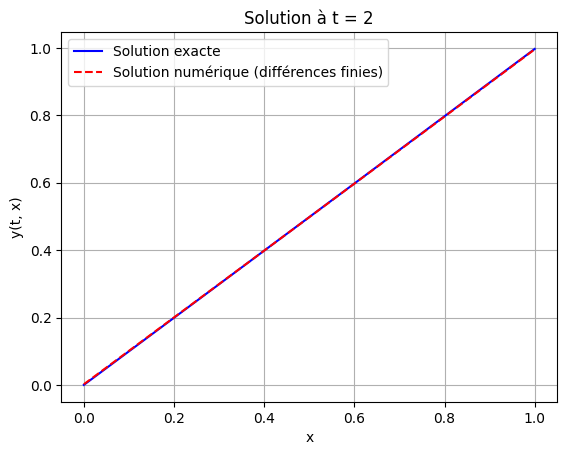

In [6]:
# Exemple avec une ulistration de la solution pour voir le taux de convergence
# Paramètres du problème
L = 1.0  # Longueur de l'intervalle
T = 2  # Temps final
Nx = 500  # Nombre de points dans l'espace
Nt = 1000  # Nombre de points dans le temps

# Fonction u(t) de la condition de Neumann
def u(t):
    return 1.0  # valeur constante de u(t)

# Résolution par différences finies
# def Finit_difference(N, T, Nt, L, u_func)
x_values, t_values, Y = Finit_difference(Nx,T, Nt, L, u)

# Solution exacte au dernier pas de temps
exact_solution = np.array([Exact(T, x, L) for x in x_values])

# Solution numérique au dernier pas de temps
numerical_solution = Y[:, -1]

# Affichage des solutions
plt.plot(x_values, exact_solution, label="Solution exacte", color='blue')
plt.plot(x_values, numerical_solution, label="Solution numérique (différences finies)", color='red', linestyle='dashed')
plt.xlabel('x')
plt.ylabel('y(t, x)')
plt.title(f'Solution à t = {T}')
plt.legend()
plt.grid(True)
plt.show()


3. Appelons $ p $, l'état adjoint introduit pour calculer le gradient de $ J $. On appelle $ q $ la fonction définie sur $[0, T] \times [0, L]$ par $ q(t, x) = p(T - t, x) $. Quelle est l'équation satisfaite par $ q $ ? En déduire une méthode numérique permettant de calculer le gradient de $ J $ en $ u $.


#### Équation pour $ q(t, x) $
nous supponsons que $ q(t, x) = p(T - t, x) $ alors on a :
$$
\frac{\partial q}{\partial t} = -\frac{\partial p}{\partial s}, \quad \text{avec} \quad s = T - t.
$$
pour la dérvié spacial on a pas de probleme 
$$
\frac{\partial^2 q}{\partial x^2} = \frac{\partial^2 p}{\partial x^2}.
$$

Ainsi, $ q(t, x) $ satisfait l'équation suivante, en remplaçant $ p $ par $ q $ et en utilisant la relation entre $ t $ et $ s $ :
$$
- \frac{\partial q}{\partial t} + \frac{\partial^2 q}{\partial x^2} = 0.
$$
Les conditions aux bords de $ q(t, x) $ sont déterminées par les conditions de $ p(t, x) $. Comme $ q(t, x) = p(T - t, x) $, les conditions aux bords pour $ q $ sont les suivantes :

- $ q(0, x) = p(T, x) = 0 $,
- $ q(t, 0) = p(T - t, 0) = 0 $,
- $ \frac{\partial q}{\partial x}(t, L) = \frac{\partial p}{\partial x}(T - t, L) = y_u(T-t, L) - z_d(T-t) $

Ainsi, $ q(t, x) $ satisfait le problème suivant :

$$
\begin{cases}
    \partial_t q(t, x) - \partial_{xx} q(t, x) = 0 &  t \in ]0, T[,\ x \in ]0, L[ \\
    q(0, x) = 0 &  x \in [0, L] \\
    q(t, 0) = 0 &  t \in [0, T] \\
    \partial_x q(t, L) = y_u(T - t, L) - z_d(T - t) &  t \in [0, T]
\end{cases}
$$




#### Une méthode numérique permettant de calculer le gradient de $J$ en $u$ :
Pour cela, nous allons utiliser la méthode de notre cours, c'est-à-dire : l'algorithme de descente de gradient.

$\underline{Initialisation :}  u^{0} \in   L^2(]0, T[)$

$\underline{Itération \space k :}  \text{ pour } u^{k} \text{ donné }$
* On commance a caculer le dual $y_u$
    $$
    \begin{cases}
        \partial_t y_u^k(t, x) - \partial_{xx} y_u^k(t, x)= 0, & (t, x) \in ]0, T[ \times ]0, L[ \\
        y_u^k(0, x) = 0, & x \in [0, L] \\
        y_u^k(t, 0) = 0, & t \in [0, T] \\
        \partial_x y_u^k(t, L) = u(t), & t \in [0, T]
    \end{cases}
    $$
* on calclue le primal $p$
    $$
    \begin{cases}
        \partial_t p^{k}(t, x) + \partial_{xx} p^{k}(t, x) = 0 &  t \in ]0, T[,\ x \in ]0, L[ \\
        p^{k}(0, x) = 0 &  x \in [0, L] \\
        p^{k}(t, 0) = 0 &  t \in [0, T] \\
        \partial_x p^{k}(t, L) = y_u^k(T - t, L) - z_d(T - t) &  t \in [0, T]
    \end{cases}
    $$
* On calcule le gradient $J$ en $u^k$

    $$
    g^k = p^k(t, L)  + \alpha u^k(t)
    $$

* On calcule le contrôle à l'itération k+1

    $$
    u^{k+1} = u^k - \rho g^k
    $$
* Critère d'arrêt

    $$
    \| u^{k+1} - u^k \| < \epsilon
    $$


4. Écrire un algorithme pour résoudre numériquement le problème $ (P) $.


### Schéma numérique pour le problème adjoint

Pour résoudre le problème adjoint, on suggère d'utiliser le même schéma que pour le problème direct. Puisque $ p(x, t) $ est solution de l'équation de la chaleur rétrograde, il convient d'inverser le temps et on pose $ t_n = T - n \Delta t $. On désigne par $ p_i^n $ l'approximation de $ p $ telle que $ p_i^n \approx p(x_i, t_n) $ avec $(i, n) \in \{1, \ldots, N\} \times \{0, \ldots, N_t\}$.

On peut montrer (et il faut le faire) que l'adjoint $ p $ résout l'équation de la chaleur rétrograde
$$
\begin{cases}
\partial_t p(t, x) + \partial_{xx} p(t, x) = 0 & t \in [0, T], x \in [0, L] \\
p(T, x) = 0 & x \in [0, L] \\
p(t, 0) = 0 & t \in [0, T] \\
\partial_x p(t, L) = y_u(t, L) - z_d(t) & t \in [0, T].
\end{cases}
$$
et le schéma s'écrit
$$
\left( I + \frac{\Delta t}{\Delta x^2} A \right) P^n = \frac{\Delta t}{\Delta x} c^n + P^{n+1}, \quad \forall n \in \{0, \ldots, N_t\},
$$
avec
$$
P^n = \begin{pmatrix}
p_1^n \\
\vdots \\
p_i^n \\
\vdots \\
p_N^n
\end{pmatrix}, \quad A = \begin{pmatrix}
2 & -1 & 0 & \cdots & 0 \\
-1 & 2 & \cdots & \cdots & \vdots \\
0 & \cdots & \cdots & \cdots & 0 \\
\vdots & \cdots & \cdots & 2 & -1 \\
0 & \cdots & 0 & -1 & 1
\end{pmatrix}, \quad c^n = \begin{pmatrix}
0 \\
\vdots \\
0 \\
\vdots \\
y_N^{n+1} - z_d(t_n)
\end{pmatrix}.
$$

In [7]:
# Schéma en temps pour le problème adjoint
def Adjoint_difference(N, T, Nt, L, y_u, z_d):
    dt = T / Nt
    dx, x = discr(N, 0, L)
    t = np.linspace(0, T, Nt + 1)
    p = np.zeros((N + 1, Nt + 1))
    p[:, -1] = np.zeros(N + 1)
    I = np.eye(N + 1)
    A = Poisson(N + 1)
    D = (I + (dt / dx**2) * A)
    D_inv = np.linalg.inv(D)  # Calculer l'inverse une fois
    for n in range(Nt - 1, -1, -1):
        c = np.zeros(N + 1)
        c[-1] = y_u[-1, n + 1] - z_d(t[n])
        p[:, n] = D_inv @ (p[:, n + 1] + (dt / dx) * c)
    return x, t, p

# Fonction pour calculer le gradient de J
def gradient_J(p, u, epsilon):
    return p + epsilon * u

# Algorithme de descente de gradient
def gradient_descent(N, T, Nt, L, epsilon,z_d,rho, beta, max_iter):
    # Initialisation
    u = np.zeros(Nt + 1)
    k = 0
    while k < max_iter:
        # Calcul du dual y_u
        x, t, y_u = Finit_difference(N, T, Nt, L, lambda t: u[int(t / (T / Nt))])
        # Calcul du primal p
        x, t, p = Adjoint_difference(N, T, Nt, L, y_u, z_d)
        # Calcul du gradient
        g = gradient_J(p[-1, :], u, epsilon)
        # Mise à jour du contrôle
        u_new = u - rho * g
        # Critère d'arrêt
        if np.linalg.norm(u_new - u) < beta:
            break
        u = u_new
        k += 1
    return u, y_u,p

5. Tester cet algorithme pour diverses valeurs de $ \alpha $, $ T $ et $ z_d $. Commenter et illustrer les résultats (on discutera en particulier l'influence des paramètres du problème sur sa résolution).

In [8]:
# Fonction pour tester l'algorithme de descente de gradient
def Test(val_epsilon, T_values, z_d,N,Nt,L):
    # Création de la matrice de sous-graphiques 3x3
    fig, ax = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(12, 8))
    fig.suptitle("Contrôle optimal de l'équation de la chaleur", fontsize=16)
    for i, T in enumerate(T_values):
        for j, epsilon in enumerate(val_epsilon):
            # Résolution du problème avec descente de gradient
            u_control, y_dual,p_primal = gradient_descent(N, T, Nt, L, epsilon,z_d, rho=0.01,beta=1e-6, max_iter=1000)
            # Visualisation des résultats
            # Affichage du contrôle optimal u(t)
            ax[i, j].plot(np.linspace(0, T, Nt + 1), u_control, label=f'$u(t)$, T={T}, $\\epsilon$={epsilon}')
            # Affichage de la trajectoire optimale y_dual(t, L)
            ax[i, j].plot(np.linspace(0, T, Nt + 1), y_dual[-1, :], label=f'$y_dual(t, L)$, T={T}, $\\epsilon$={epsilon}')
            # Affichage de la donnée z_d(t)
            # Zd = z_d(np.linspace(0, T, Nt + 1))
            ax[i, j].plot(np.linspace(0, T, Nt + 1), p_primal[-1, :], label=f'$p_primal(t,L)$, T={T}, $\\epsilon$={epsilon}')
            ax[i, j].set_title(f'T={T}, $\\epsilon$={epsilon}')
    # Ajustements des paramètres globaux des sous-graphiques
    for a in ax.flat:
        a.set(xlabel='Temps t', ylabel='Valeurs')
        a.legend()
        a.grid(True)
    # Ajustement de l'espacement entre les sous-graphiques
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

Premier test avec différentes valeurs de $ t $ et $ \alpha $ avec la fonction $ z_d $ suivante :
$$
z_d = \exp(-t) \cos(t)
$$

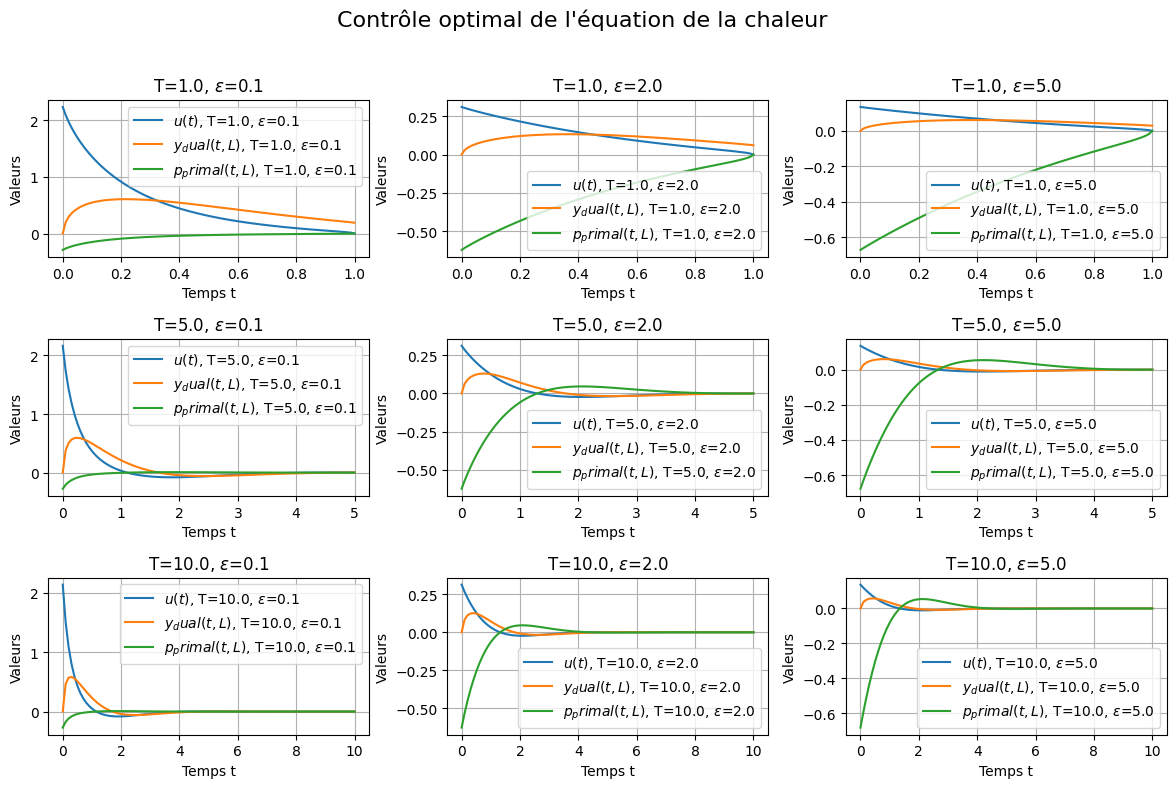

In [9]:
# Paramètres à faire varier
Nx = 100
Nt = 100
L = 1.0
t = [1.0, 5.0, 10.0]
epsilon = [0.1, 2.0, 5.0]
def z_d(t):
    return np.exp(-t)*np.cos(t)
Test(epsilon,t, z_d,Nx,Nt,L)

Deuxième test avec différentes valeurs de $ t $ et $ \alpha $ avec la fonction $ z_d $ suivante :
$$
z_d = \exp(-t^2)
$$

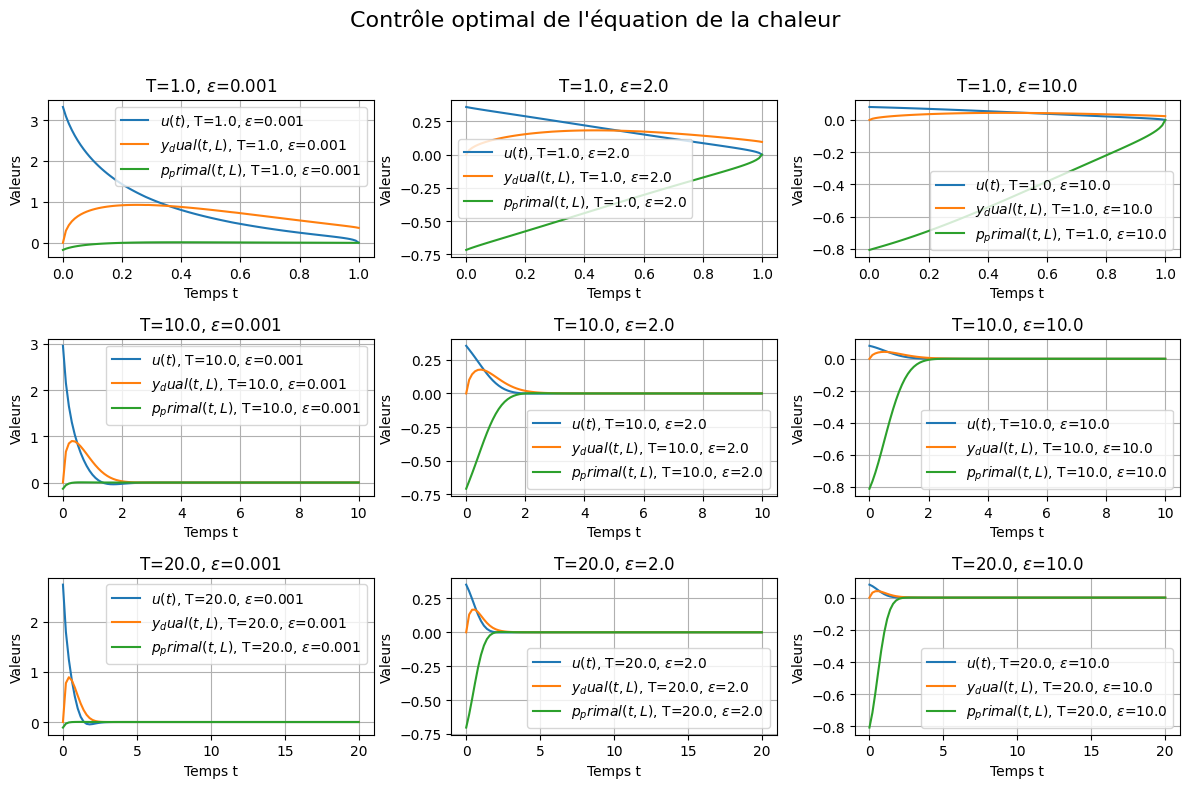

In [10]:
# Paramètres à faire varier
Nx = 100
Nt = 100
L = 1.0
t = [1.0, 10.0, 20.0]
epsilon = [0.001, 2.0, 10.0]
def z_d(t):
    return np.exp(-t**2)
Test(epsilon,t, z_d,Nx,Nt,L)

Troisième test avec différentes valeurs de $ t $ et $ \alpha $ avec la fonction $ z_d $ suivante :
$$
z_d = \sin(\pi t) \cos(\pi t)
$$

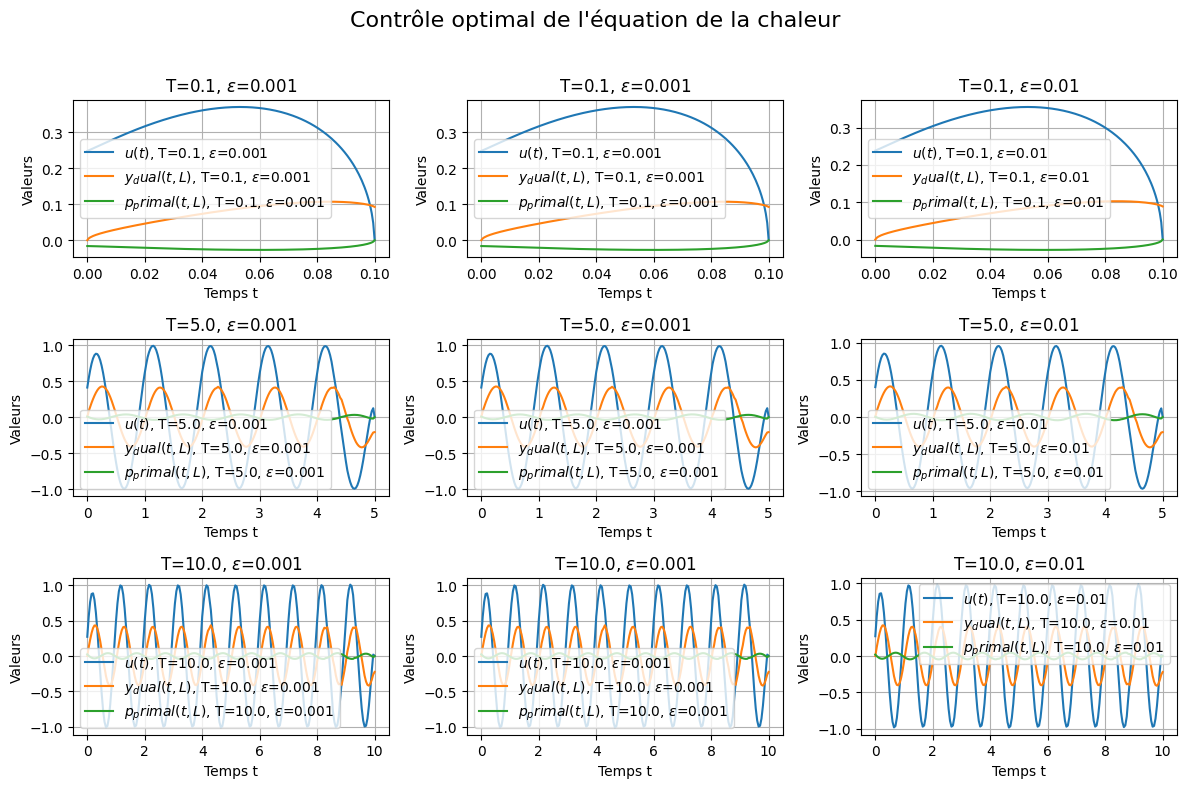

In [11]:
# Paramètres à faire varier
Nx = 200
Nt = 200
L = 1.0
t = [0.1, 5.0, 10.0]
epsilon = [0.001, 0.001, 0.01]
def z_d(t):
    return np.sin(np.pi*t)*np.cos(np.pi*t)
Test(epsilon,t, z_d,Nx,Nt,L)

D'après les tests que nous avons effectués pour différentes valeurs de $ \epsilon $, de $ z_d $ et de $ T $, nous constatons que notre algorithme contrôle bien le problème de la chaleur. Nous observons que $ \epsilon $ joue un rôle très important dans la régularisation, en pénalisant les grandes valeurs de $ u(t) $. De même, lorsque le temps $ T $ augmente, le système dispose de plus de temps pour s'ajuster, ce qui peut entraîner des contrôles plus doux et une meilleure correspondance avec $ z_d(t) $. Les trajectoires $ y_u(t, L) $ et $ p(t, L) $ montrent une bonne correspondance avec $ z_d(t) $ pour des valeurs intermédiaires de $ \epsilon $ et de $ T $, ce qui suggère un bon compromis entre réactivité et régularisation.